In [6]:
import pathlib
import numpy as np
from scipy.fftpack import fft
import scipy.signal as signal
import yaml

ROWS = 250
OBSERVATION_ID = "2018-01-31-22-25-29.828411"

#OBSERVATION_ID = "test"


path = pathlib.Path('../observations')

params = yaml.load(open(path.joinpath('params.yaml')))

sample_rate = int(float(params['sample_rate_hz']))


fs = int(sample_rate * params['observation_secs'])
bins = fs
bins=2**14
intervals = None

with open(path.joinpath('intervals')) as f:
    intervals = [str(line).strip() for line in f]

#intervals = intervals[750:900]
    
print(len(intervals))

if(len(intervals) < ROWS):
    ROWS = len(intervals)

k = len(intervals)//ROWS 



print(k)
avg_powers_target = None
avg_powers_blank = None
avg_powers = None
for i in range(0,ROWS):
    scratch = None
    for j in range(0,k):
        r = np.load(path.joinpath(intervals[(i*k)+j]+'.npz'))['arr_0']
        freqs, scratch_tmp = signal.welch(r, fs=sample_rate, return_onesided=False, nperseg=bins)

        if scratch is None:
            scratch = np.empty([k,freqs.shape[0]])
        if avg_powers is None:
            avg_powers = np.empty([ROWS,freqs.shape[0]])
            avg_powers_target = np.empty([ROWS,freqs.shape[0]])
            avg_powers_blank = np.empty([ROWS,freqs.shape[0]])
            
        scratch[j] = np.fft.fftshift(scratch_tmp)
    target = np.mean(scratch, axis=0)
    scratch_blank = None  
    
    for j in range(0,k):
        r = np.load(path.joinpath(intervals[(i*k)+j]+'_blank.npz'))['arr_0']
        f_tmp, scratch_tmp = signal.welch(r, fs=sample_rate, return_onesided=False, nperseg=bins)
        
        if scratch_blank is None:
            scratch_blank = np.empty([k,freqs.shape[0]])
            
        scratch_blank[j] = np.fft.fftshift(scratch_tmp)

        
    blank = np.mean(scratch_blank, axis=0)    
    

    avg_powers_target[i] = target
    avg_powers_blank[i] = blank
    
    #print(i*k)

    


avg_powers = (avg_powers_target-avg_powers_blank)/avg_powers_blank
    
avg_powers[avg_powers == 1] = 0
avg_powers[avg_powers < 0] = 0
avg_powers[avg_powers == 0] = np.amin(avg_powers[np.nonzero(avg_powers)])

freqs = np.fft.fftshift(freqs)
means = np.mean(avg_powers, axis=0)

print(np.mean(avg_powers_blank, axis=1))

18
1
[1.98082765e-11 1.97960755e-11 1.97835618e-11 1.97788550e-11
 1.98082765e-11 1.97762758e-11 1.98082765e-11 1.96659695e-11
 1.97573618e-11 1.97704847e-11 1.97395724e-11 1.90149075e-11
 1.96699669e-11 1.97621325e-11 1.97608504e-11 1.96867933e-11
 1.96799746e-11 1.96925671e-11]


/Users/Paul/Documents/Projects/NADIA/env/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


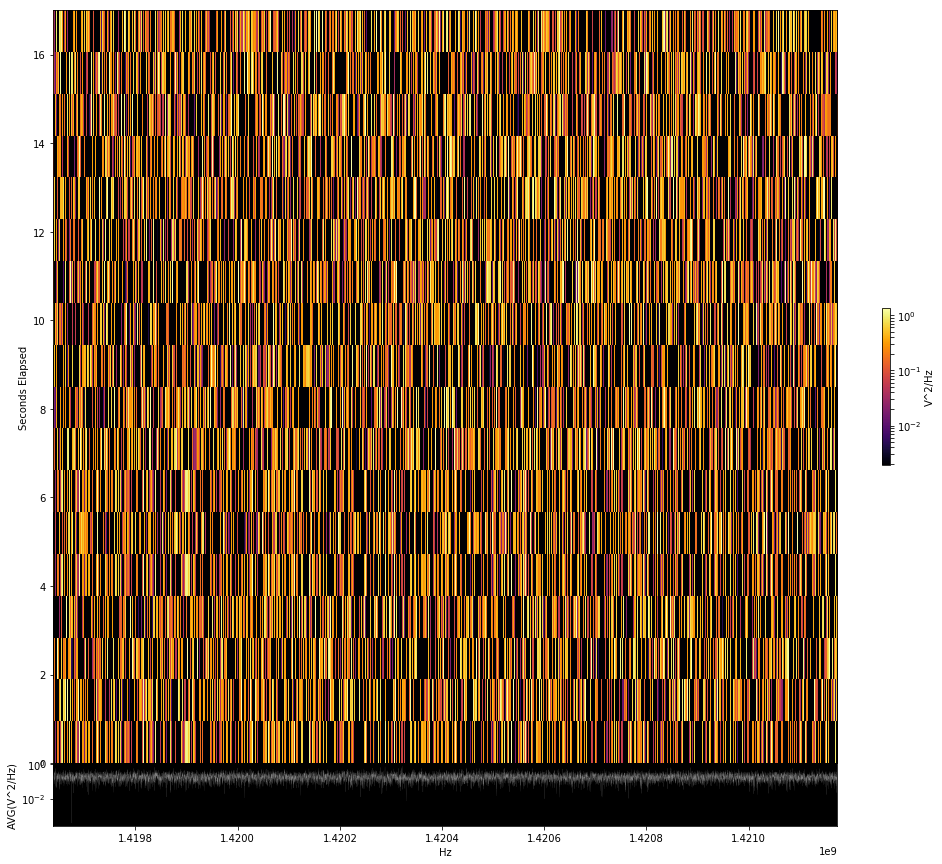

1419637750.0
1421173656.25
1419637750.0
1421173656.25


In [10]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

WIDTH_HZ = 2e6
OFFSET_HZ = 0000000

freq = params['center_freq_hz']
if WIDTH_HZ is None:
    bw = params['bandwidth_hz']
else:
    bw = WIDTH_HZ

if WIDTH_HZ is not None:
    indices = np.absolute(freqs+OFFSET_HZ) < WIDTH_HZ/2
    freqs_slice = freqs[indices]
    means_slice = means[indices]
    avg_powers_slice = avg_powers[:,indices]
else:
    freqs_slice = freqs[:]
    means_slice = means[:]
    avg_powers_slice = avg_powerstarget[:]

min_freq = np.amin(freqs_slice)+freq
max_freq = np.amax(freqs_slice)+freq

# , figsize=(20,30)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15), gridspec_kw = 
                     {'height_ratios':[12, 1], 'width_ratios':[15, 1]})
f.subplots_adjust(hspace=0, wspace=0)
ax[0][0].set_xlim(0, avg_powers_slice.shape[1])

waterfall = ax[0][0].pcolorfast(freqs_slice+freq, np.arange(0, len(avg_powers_slice)*k), avg_powers_slice, cmap='inferno',
             norm=LogNorm(np.mean(avg_powers_slice)/100, np.amax(avg_powers_slice)/5), 
            )

ax[0][0].set_xlim(min_freq, max_freq)
ax[0][0].set_ylabel("Seconds Elapsed")

ax[1][0].set_xlim(min_freq, max_freq)

ax[1][0].set_facecolor('k')
ax[1][0].plot(freqs_slice+freq, means_slice, color='w', alpha=0.5, linewidth=0.1)
ax[1][0].set_yscale('log')
ax[1][0].set_ylabel("AVG(V^2/Hz)")
ax[1][0].set_xlabel("Hz")

cbar = f.colorbar(waterfall, ax=ax[0][1])
cbar.set_label('V^2/Hz')
ax[0][1].set_axis_off()
ax[1][1].set_axis_off()
ax[0][1].set_ylabel('V^2/Hz', rotation=270)

plt.show()
print(np.amin(freqs)+freq)
print(np.amax(freqs)+freq)
print(min_freq)
print(max_freq)